# 图像特效-图像抖动

In [31]:
from scipy import signal
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

In [32]:
src = cv2.imread('../datas/p3.jpg')
gray = cv2.imread('../datas/p3.jpg',0)
rgb = cv2.cvtColor(src,cv2.COLOR_BGR2RGB)

In [33]:
def dither(src):

#     img = img.convert('L')
    img = src.astype(np.int32)
    threshold = 128*[0] + 128*[255]
    rows,cols = img.shape[0],img.shape[1]
    dst = np.zeros_like(img).astype(np.float32)
    
    for y in range(rows):
        for x in range(cols):

            old = img[y,x]
            new = threshold[int(old)]
            err = (old - new) >> 3 # divide by 8
            
#             img.putpixel((x, y), new)
            dst[y,x] = new
        
            for nxy in [(x+1, y), (x+2, y), (x-1, y+1), (x, y+1), (x+1, y+1), (x, y+2)]:
                try:
#                     img.putpixel(nxy, img.getpixel(nxy) + err)
                    dst[nxy] = img[nxy] + err
                except IndexError:
                    pass
            
    dst = np.clip(dst,0,255)
    return dst.astype(np.uint8)

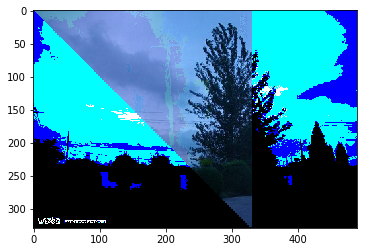

In [34]:
dstr = dither(rgb[:,:,0])
dstg = dither(rgb[:,:,1])
dstb = dither(rgb[:,:,2])
dst = cv2.merge([dstr,dstg,dstb])
plt.imshow(dst)

In [43]:
RED = 0.212656
GREEN = 0.715158
BLUE = 0.072186
luma_correction = (
    1.0 / GREEN * RED,
    1.0,
    1.0 / GREEN * BLUE
)
# 抖动方法
floyd_steinberg = (
    (1, 0, 7.0/16),
    (1, 1, 1.0/16),
    (0, 1, 5.0/16),
    (-1, 1, 3.0/16)
)

jarvis_judice_and_ninke = (
    (1, 0, 7.0/48),
    (1, 1, 5.0/48),
    (0, 1, 7.0/48),
    (-1, 1, 5.0/48),
    (2, 0, 5.0/48),
    (2, 1, 3.0/48),
    (2, 2, 1.0/48),
    (1, 2, 3.0/48),
    (0, 2, 5.0/48),
    (-1, 2, 3.0/48),
    (-2, 2, 1.0/48),
    (-2, 1, 3.0/48)
)

stucki = (
    (1, 0, 8.0/42),
    (1, 1, 4.0/42),
    (0, 1, 8.0/42),
    (-1, 1, 4.0/42),
    (2, 0, 4.0/42),
    (2, 1, 2.0/42),
    (2, 2, 1.0/42),
    (1, 2, 2.0/42),
    (0, 2, 4.0/42),
    (-1, 2, 2.0/42),
    (-2, 2, 1.0/42),
    (-2, 1, 2.0/42)
)

atkinson = (
    (1, 0, 1.0/8),
    (1, 1, 1.0/8),
    (0, 1, 1.0/8),
    (-1, 1, 1.0/8),
    (2, 0, 1.0/8),
    (0, 2, 1.0/8)
)

burkes = (
    (1, 0, 8.0/32),
    (1, 1, 4.0/32),
    (0, 1, 8.0/32),
    (-1, 1, 4.0/32),
    (2, 0, 4.0/32),
    (2, 1, 2.0/32),
    (-2, 1, 2.0/32)
)

sierra = (
    (1, 0, 5.0/32),
    (1, 1, 4.0/32),
    (0, 1, 5.0/32),
    (-1, 1, 4.0/32),
    (2, 0, 3.0/32),
    (2, 1, 2.0/32),
    (1, 2, 2.0/32),
    (0, 2, 3.0/32),
    (-1, 2, 2.0/32),
    (-2, 1, 2.0/32)
)

two_row_sierra = (
    (1, 0, 4.0/16),
    (1, 1, 2.0/16),
    (0, 1, 3.0/16),
    (-1, 1, 2.0/16),
    (2, 0, 3.0/16),
    (2, 1, 1.0/16),
    (-2, 1, 1.0/16)
)

sierra_lite = (
    (1, 0, 2.0/4),
    (0, 1, 1.0/4),
    (-1, 1, 1.0/4)
)
class Palette(list):
    def __init__(self, distance_algorithm):
        super(Palette, self).__init__()
        if distance_algorithm == "luma":
            self.match = self.__distance_luma
        else:
            self.match = self.__distance_red_mean

    def __distance_luma(self, r,g,b):
        """
        use Euclidean distance
        to find the best color matching in the palette
        """
        minimum = float("inf")
        minimum_index = 0
        index = 0
        for red, green, blue in self:
            red = red - r
            green = green - g
            blue = blue - b
            red = red * red * RED
            green = green * green * GREEN
            blue = blue * blue * BLUE
            rgb = red + green + blue
            if rgb < minimum:
                minimum = rgb
                minimum_index = index
            index += 1
        return minimum_index

    def __distance_red_mean(self, r,g,b):
        minimum = float("inf")
        minimum_index = 0
        index = 0
        for red, green, blue in self:
            rmean = (red + r) / 2.0
            red = red - r
            green = green - g
            blue = blue - b
            red = red * red * (2.0 + rmean / 256.0)
            green = green * green * 4.0
            blue = blue * blue * (2.0 + (255.0 - rmean) / 256.0)
            rgb = red + green + blue
            if rgb < minimum:
                minimum = rgb
                minimum_index = index
            index += 1
        return minimum_index

    @property
    def chain(self):
        result = []
        for rgb in self:
            rgb = map(int, rgb)
            result.extend(rgb)
        return result
    
class MedianCut(Palette):
    def __init__(self, pixel, distance_algorithm, use_luma=False):
        super(MedianCut, self).__init__(distance_algorithm)
        for rgb in quantization(pixel.cursor, use_luma):
            self.append(rgb)
            
def dithering_wraper(image, formula, use_luma=False):
    #formula = formula.replace("-", "_")
    #formula = getattr(formulas, formula, None)

    def wrapper(x, y, rgb):
        if formula is None:
            return
        error = map(sub, image[x, y], rgb)
        if use_luma:
            error = map(mul, error, luma_correction)
        for xd, yd, rate in formula:
            xd = xd + x
            yd = yd + y
            if not (0 <= xd < image.x and 0 <= yd < image.y):
                continue
            rgb = []
            for color, color_error in zip(image[xd, yd], error):
                color = color + color_error * rate
                if color < 0:
                    color = 0.0
                elif color > 255:
                    color = 255.0
                rgb.append(color)
            image[xd, yd] = rgb
    return wrapper
def dithering(image, formula, use_luma=False):
    dith = dithering_wraper(image,formula,use_luma)
    rows,cols = image.shape[0],image.shape[1]
    dst = np.zeros_like(image).astype(np.float32)
    imagef = np.float32(image)
    palette = Palette("luma")
    for i in range(rows):
        for j in range(cols):
            color = imagef[i,j]
            index = palette.match(color[0],color[1],color[2])
            dst[i,j] = index
            dith(j,i,palette[index])
    return dst

In [44]:
dst = dithering(rgb,floyd_steinberg,True)
plt.imshow(dst)

IndexError: list index out of range

In [ ]:
print(dst)